In [52]:
from concurrent.futures import ThreadPoolExecutor

import geopandas as gpd
import numpy as np
import odc.geo  # noqa: F401
from dea_tools.classification import predict_xr
from odc.stac import load
from pystac_client import Client
from shapely import geometry
from sklearn.ensemble import RandomForestClassifier

In [111]:
fiji_bbox = [177.2, -18.4, 178.9, -17.2]
fiji_bbox_geometry = geometry.box(*fiji_bbox)
fiji_bbox_geometry

# training_file = "training_data/lulc_bare_land.geojson"
training_file = "training_data/lulc_combined.geojson"

tdata = gpd.read_file(training_file, bbox=fiji_bbox_geometry)
tdata.explore()

In [3]:
collection = "dep_ls_geomad"

client = Client.open("https://stac.staging.digitalearthpacific.org")

items = list(client.search(
    collections=[collection],
    bbox=fiji_bbox,
    datetime="2023"
).items())

print(f"Found {len(items)} items")

Found 6 items


## Note to future Nick

Wait for Alex to produce S-2 GeoMAD, then do the real work with that.

Between now and then, experiment with doing another LOAD step, like we're doing here, but with S-1.

So do the following:

* Search the MSPC STAC API for S-1 Items over our BBOX area over the year of interest
* Load them using odc.stac.load and do an annual summary, probably using a mean over time
* Maybe compute stdev too
* then add a HH/HV too, so you'll have a single timestep with HH_Mean, HV_Mean, HH_StdDev, HV_StdDev and HH/HV
* That can be added to the below data from GeoMAD.

Hint, when you use `load`, you can pass in the existin data. So first load GeoMad, then get `load(items, geobox=data.geobox)` 


In [113]:
bands = [
    "red",
    "green",
    "blue",
    "nir08",
    "swir16",
    "swir22",
    "emad",
    "bcmad",
    "smad",
]

data = load(
    items,
    measurements=bands,
    chunks={"x": 100, "y": 100, "time": 1},
)

data = data.squeeze("time")

data

<xarray.Dataset>
Dimensions:      (y: 6401, x: 9600)
Coordinates:
  * y            (y) float64 -1.888e+06 -1.888e+06 ... -2.08e+06 -2.08e+06
  * x            (x) float64 2.952e+06 2.952e+06 2.952e+06 ... 3.24e+06 3.24e+06
    spatial_ref  int32 3832
    time         datetime64[ns] 2023-01-01
Data variables:
    red          (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    green        (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    blue         (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    nir08        (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    swir16       (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    swir22       (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    emad         (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    bcmad        (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    smad         (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>

In [ ]:
# Get S-1

# Get the URL for STAC API on MSPC
# Get a pystac client for the MSPC
# Search for datasets
# Load data using the existing geomad geobox
# Create means over time

In [131]:
projected_training_data = tdata.to_crs("EPSG:3832")
training_array = []

def get_training_data(id_row):
    _, row = id_row
    cls = row["lulc_class"]
    # Add more classes as integers here.
    # Maybe use a look-up table.
    cls_id = 1 if cls == "bare_land" else 0
    id = row["id"]
    geom = row["geometry"]

    # Get xarray values at the point
    x = data.sel(x=geom.x, y=geom.y, method="nearest").compute()
    one_point = [id] + [cls_id] + [float(v) for v in x.values()]
    return one_point

with ThreadPoolExecutor(max_workers=10) as executor:
    training_array = list(executor.map(get_training_data, projected_training_data.iterrows()))

print(f"Fetched data for {len(training_array)} training points")

Fetched data for 504 training points


In [133]:
classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_leaf=10,
    n_jobs=-1,
    random_state=42,
)

training_data = np.array(training_array)[:, 2:]
classes = np.array(training_array)[:, 1]

model = classifier.fit(training_data, classes)

In [142]:
# This is for a small subset region
# ll = -17.82845, 177.30492
# ur = -17.49281, 177.77527
# predict_data = load(items, bbox=(ll[1], ll[0], ur[1], ur[0]), measurements=bands, chunks={})

# This one loads all the data from all Viti Levu
predict_data = load(items, bbox=fiji_bbox, measurements=bands, chunks={})

predict_data = predict_data.compute()

predict_data = predict_data.squeeze("time")
predict_data = predict_data.fillna(-9999)
predict_data

<xarray.Dataset>
Dimensions:      (y: 4649, x: 6309)
Coordinates:
  * y            (y) float64 -1.932e+06 -1.932e+06 ... -2.071e+06 -2.071e+06
  * x            (x) float64 3.028e+06 3.028e+06 ... 3.217e+06 3.217e+06
    spatial_ref  int32 3832
    time         datetime64[ns] 2023-01-01
Data variables:
    red          (y, x) float32 7.248e+03 7.244e+03 ... 7.159e+03 7.214e+03
    green        (y, x) float32 7.696e+03 7.716e+03 ... 7.349e+03 7.401e+03
    blue         (y, x) float32 8.17e+03 8.186e+03 ... 7.52e+03 7.644e+03
    nir08        (y, x) float32 7.295e+03 7.285e+03 ... 7.32e+03 7.343e+03
    swir16       (y, x) float32 7.526e+03 7.522e+03 ... 7.685e+03 7.653e+03
    swir22       (y, x) float32 7.526e+03 7.525e+03 ... 7.668e+03 7.634e+03
    emad         (y, x) float32 578.4 601.0 633.4 532.1 ... 616.3 598.1 507.0
    bcmad        (y, x) float32 0.01387 0.01457 0.01377 ... 0.01348 0.01175
    smad         (y, x) float32 0.0004207 0.0004491 ... 0.0003076 0.0002503

In [146]:
# This runs the actual prediction
predicted = predict_xr(model, predict_data, proba=True)

predicting...
   probabilities...


/opt/homebrew/lib/python3.11/site-packages/distributed/client.py:3148: UserWarning: Sending large graph of size 27.97 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


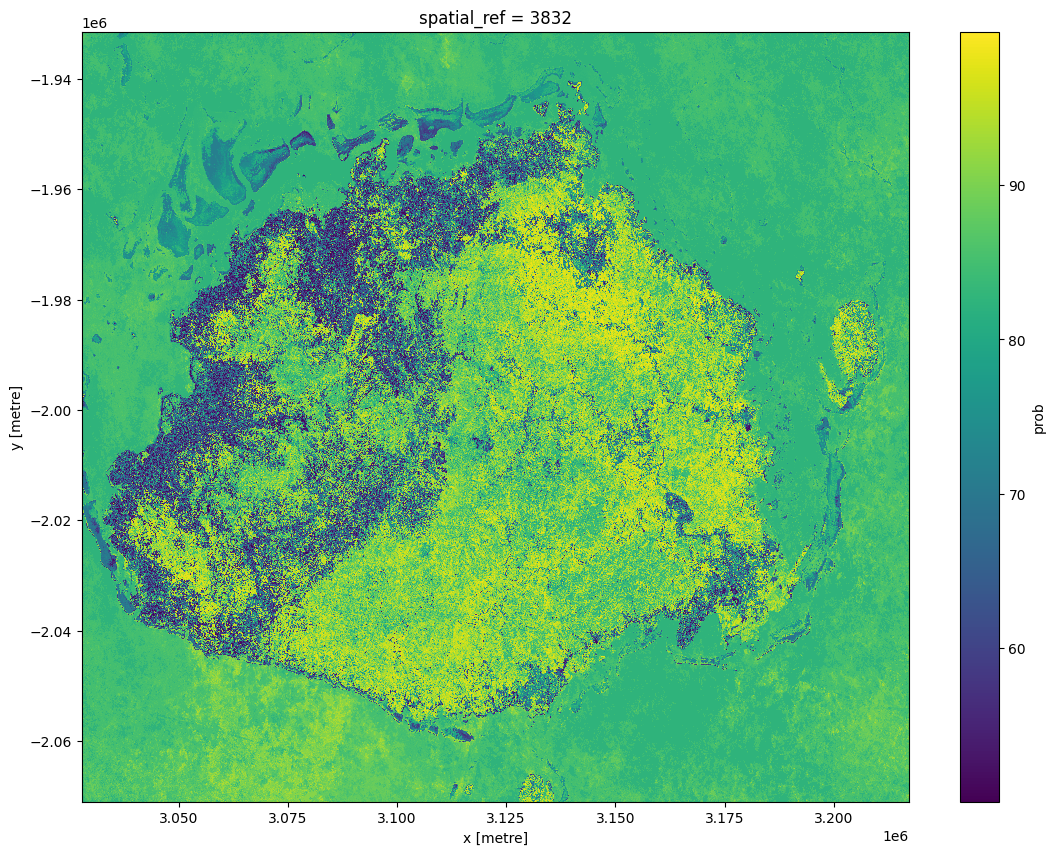

In [148]:
# Convert to int
cleaned_predictions = predicted.copy(deep=True)
cleaned_predictions.Predictions.data = predicted.Predictions.data.astype(np.int8)
cleaned_predictions.Probabilities.data = predicted.Probabilities.data.astype(np.float32)

cleaned_predictions = cleaned_predictions.rename({"Predictions": "lulc", "Probabilities": "prob"})

cleaned_predictions.prob.plot.imshow(size=10)

In [150]:
# Write GeoTIFF
cleaned_predictions.prob.odc.write_cog("prob_fiji.tif", overwrite=True)

PosixPath('prob_fiji.tif')